# Working with Databricks outside of the UI

## Lets query the ingested data

In [1]:
from pyspark.sql import DataFrame, SparkSession
import pandas as pd

In [2]:
# Spark here is handled by the databricks-connect library
# 
# Once installed it's configured by calling "databricks-connect configure" where we provide details on how
# to connect to our cluster. The version of databricks-connect installed must match the Databricks Runtime
# version on the cluster

spark: SparkSession = SparkSession.builder.getOrCreate()

asset_id: int = int(spark.sql("SELECT MAX(AssetNumber) FROM silver.events").head()[0])

df: DataFrame = spark.sql(f"SELECT * FROM silver.events WHERE AssetNumber = {asset_id}")

df.show()

+-----------+----------+-------------------+--------+-------------------+--------------------+----------+-----------+---------+
|AssetNumber|   EventTs|          EventDate| DateKey|              Value|         Description|IngestYear|IngestMonth|IngestDay|
+-----------+----------+-------------------+--------+-------------------+--------------------+----------+-----------+---------+
|      15959|1569934928|2019-10-01 14:02:08|20191001| 0.3617881666807856|                null|      2019|         10|        1|
|      15959|1569934937|2019-10-01 14:02:17|20191001|0.08535568452166964|                null|      2019|         10|        1|
|      15959|1569934960|2019-10-01 14:02:40|20191001| 0.8576700377774823|                null|      2019|         10|        1|
|      15959|1569935202|2019-10-01 14:06:42|20191001| 0.8365810597662551|                null|      2019|         10|        1|
|      15959|1569935207|2019-10-01 14:06:47|20191001|0.35613913892901217|                null|      2019

## Now lets query the data, aggregate it, and pull it back locally as a Pandas DataFrame so that we can plot it

In [3]:
# Now lets read the data for the asset and bucket the data into hours with the average
# value for the hour

grouped_df: DataFrame = spark.sql(("SELECT "
                                  "    AssetNumber "
                                  "    , DATE_TRUNC('HOUR', EventDate) AS EventDateHour "
                                  "    , AVG(Value) AS AverageValue "
                                  "FROM "
                                  "    silver.events "
                                  "WHERE "
                                  f"    AssetNumber = {asset_id} "
                                  "GROUP BY "
                                  "    AssetNumber "
                                  "    , EventDateHour "
                                  "ORDER BY "
                                  "    EventDateHour"))

grouped_pd_df: pd.DataFrame = grouped_df.toPandas()

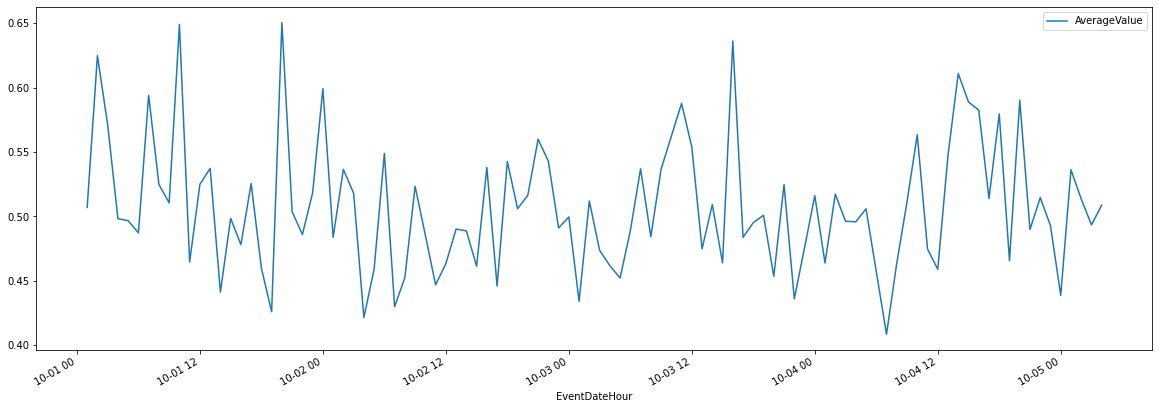

In [4]:
pd.options.plotting.backend = "matplotlib"
fig = grouped_pd_df.plot(x='EventDateHour', y='AverageValue', figsize=(20, 7))